<a href="https://colab.research.google.com/github/ZHONGCHUYUN/Mean_field_variational_inference/blob/master/VI_tutorial_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Inference Tutorial

The goal of this tutorial is to implement a Variational Autoencoder (VAE). The aim is to give you sense of:

1. How the "*reparametrization trick*" enables scaling of variational inference to large scale datasets
2. How we can amortize the inference by learning a *recognition model*

The combination of a generative model from low dimensional latent variables $z$ to high dimensional observations $x$, combined with a recognition model from $x$ to $z$ is what gives rise to the autoencoding structure. The approach we follow here was first proposed by Kingma et al. (https://arxiv.org/abs/1312.6114) and Rezende et. al. (https://arxiv.org/pdf/1401.4082.pdf).

As a brief refresher, variational inference is a general approach to doing approximate inference for intractable posterior distributions. For example, we might have a probabilistic model with observations $x$ and latent variables $z$, and we are interested in computing the posterior distribution $p(z|x)$. For relatively complex data, we might imagine the generative process from $z \to x$ to be some very complicated function we want to learn using a neural network $x = f_{\theta}(z)$. In order to compute the posterior distribution we need the normalizing factor $p(x) = \int p(x|f_{\theta}(z))p(z)dz$ which is intractable due to the non-linear mapping we have imposed with the neural network.

## Imports

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.utils import make_grid

## Setting model and train (hyper)parameters

In [0]:
batch_size = 100
epochs = 20
input_dim = 784
learning_rate = 5e-3
log_interval = 50
num_workers = 8
z_dim = 2

# cuda
cuda = False
device = torch.device("cuda" if cuda and torch.cuda.is_available() else "cpu")

## Load and visualize MNIST

The MNIST database is a database of handwritten digits that is commonly used for training and testing in the field of machine learning and computer vision. The MNIST database contains 60,000 training images and 10,000 testing images. Each image is of size $28 \times 28$.

In [0]:
def load_mnist_dl(batch_size, data_dir='/tmp/data'):
    transf = transforms.ToTensor()
    mnist_train = datasets.MNIST(data_dir, train=True, download=True, transform=transf)
    mnist_test = datasets.MNIST(data_dir, train=False, transform=transf)
    dl_kwargs = {
        'batch_size': batch_size,
        'shuffle': True,
        'num_workers': num_workers,
        'drop_last': True
    }
    train_loader = DataLoader(mnist_train, **dl_kwargs)
    test_loader = DataLoader(mnist_test, **dl_kwargs)
    return train_loader, test_loader

In [0]:
# get a data loader for each MNIST train and test set
train_loader, test_loader = load_mnist_dl(batch_size)

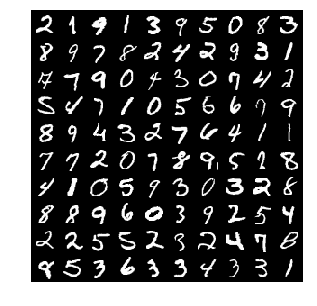

In [5]:
# get some random training images
# get the next batch from the train data loader
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images from dataset
plt.figure(figsize=(5, 5))
img_grid = make_grid(images, nrow=10)
_ = plt.imshow(img_grid.numpy().transpose(1, 2, 0))
_ = plt.axis('off')

## Generative Process

Let us consider a dataset $X = \{x_i\}^N_{i=1}$ consisting of N samples of some continuous or discrete variable x. 
We assume that the data are generated by some random process.
It starts with a latent representation $z$ sampled from a simple distribution, e.g. a standard Gaussian distribution with diagonal covariance. 
Then the samples are fed through a deep neural network ($f_{\theta}$) to capture the complex generative process of high dimensional observations such as images.
For binarized MNIST, the observation is chosen to be Bernoulli, with its parameters also parametrized by a neural network.
\begin{align}
z &\sim \mathcal{N}(0, \text{I})\\
x_{\text{logits}} &= f_{\theta}(z)\\
x &\sim \text{Bernoulli}(x; S(x_{\text{logits}})), 
\end{align}

where $S(x) = \frac{1}{1 + e^{-x}}$ is the sigmoid function.

## Inference
The objective is to approximate the posterior distribution $p_{\theta}(z|x)$. To do so, we use a mean field variational approximation. In the setting of the variational autoencoder, the variational posterior $q_{\phi}(z|x)$ is also parameterized by a neural network $f_{\phi}$ which takes input $x$ and outputs the mean and variance of a Normal distribution:

\begin{align}
\mu(x;\phi), \log \sigma^2(x;\phi) &=f_{\phi}(x)\\
q_{\phi}(z|x) &= \mathcal{N}(z|\mu(x;\phi),\sigma^2(x;\phi))
\end{align}

## ELBO

Because directly optimizing $\log p_{\theta}(x)$ is infeasible, we choose to optimize a lower bound $\mathcal{L}$ of it. The lower bound on the marginal likelihood of datapoint $i$ can be written as:
\begin{align}
\log p_{\theta}(x_i) \ge \mathcal{L}(x_i; \theta, \phi) &= \mathbb{E}_{q_{\phi}(z_i|x_i)}[\log p_{\theta}(x_i,z_i) - \log q_{\phi}(z_i|x_i)]\\
&= \mathbb{E}_{q_{\phi}(z_i|x_i)}[\log p_{\theta}(x|z)] - D_{KL}(q_{\phi}(z_i|x_i) \parallel p(z_i))
\end{align}

The KL term can be integrated analytically in our case, the expected reconstruction error $\mathbb{E}_{q_{\phi}(z|x)}[\log p_{\theta}(x|z)]$ requires estimation by sampling:

\begin{align}
\mathbb{E}_{q_{\phi}(z_i|x_i)}[\log p_{\theta}(x_i|z_i)] \simeq \frac{1}{L} \sum_{l=1}^L \log p_{\theta}(x_i|z_i^l), \; z_i^l \sim q_{\phi}(z_i | x_i)
\end{align}

According to the original paper, L can be set to 1 if the batch size is large enough ($\ge 100$).

The ELBO over one batch can be calculated with:
\begin{align}
\mathcal{L}(X; \theta, \phi) = \frac{1}{M} \sum_{i=1}^M \big(\sum_{l=1}^L \log p_{\theta}(x_i|z_i^l) - D_{KL}(q_{\phi}(z_i|x_i) \parallel p(z_i))\big)
\end{align}

## Automatic differentiation
Pytorch uses automatic differentiation (autograd) to automate the computation of backward passes in neural networks. When using autograd, the *forward* pass of your network will define a computational graph; nodes in the graph will be Tensors, and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

# Task 1: The reparametrization trick

One of the key aspects of the Kingma et. al. (https://arxiv.org/abs/1312.6114) paper was the introduction of the reparametrization trick. The problem we run into with training the VAE is that we need the gradient of an expectation of the lower bound w.r.t. the parameters of the variational distribution. I.e. $\nabla_{\phi}\mathcal{L}(x_i; \theta, \phi)$ in the equations above. Without going into detail (see http://blog.shakirm.com/2015/10/machine-learning-trick-of-the-day-4-reparameterisation-tricks/ for a great tutorial), we can avoid this problem for some distributions by reparameterizing our random variable in terms of a deterministic function and a random variable that is independent of the parameters we wish to take the gradient with respect to.

For a Gaussian distribution, we can get an unbias estimate of the monte-carlo approximation of the expectations by taking a sample from a normal gaussian $\epsilon \sim \mathcal{N}(0, I)$ and the reparameterized sample is then given by

\begin{align}
z_i^l = \mu(x;\phi) + \sigma(x;\phi) * \epsilon
\end{align}

Finish the *reparametrize* function in the VAE class below.


In [0]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, z_dim=2):
        super(VAE, self).__init__()
        # Use the nn.Module package to define the VAE model as a sequence of layers.
        # nn.Sequential s a Module which contains other Modules, 
        # and applies them in sequence to produce its output.
        # Each Linear module (nn.Linear) computes output from input using a
        # linear function, and holds internal Tensors for its weight and bias.

        # inference network q(z|x)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        # mean and log(var)
        self.mu = nn.Linear(128, z_dim)
        self.logvar = nn.Linear(128, z_dim)
        
        # generator network p(x|z)
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

    def reparametrize(self, mu, logvar):
        """
        Use mu and log(var) to sample z ~ N(mu, var)
        Parameters
        ----------
        mu: pytorch Tensor of shape (N, z_dim)
        logvar: pytorch Tensor of shape (N, z_dim)
        Returns
        -------
        z: pytorch Tensor of shape (N, z_dim)
        """
        e = torch.randn_like(mu)
        # Edit this function      
        var = torch.exp(logvar)
        z = mu + var*e
       
        return z

    def forward(self, x):
        """
        Parameters
        -----------
        x: pytorch Tensor of shape (N, input_dim)
        Returns
        -------
        recon_x: pytorch Tensor of shape like x
        mu: pytorch Tensor of shape (N, z_dim)
        logvar: pytorch Tensor of shape (N, z_dim)
        """
        h = self.encoder(x)
        mu = self.mu(h)
        logvar = self.logvar(h)
        z = self.reparametrize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

## Task 2: KL divergence
In the function KL you are supposed return the KL between a parametrized Gaussian distribution $\mathcal{N}(\mu(x, \phi), \sigma^2(x, \phi))$ and $\mathcal{N}(0, I)$. 

In [0]:
def KL(mu, logvar):
    """
    Computes the KL divergence between N(mu, exp(logvar)I) and N(0, I).
    Parameters
    ----------
    mu: pytorch Tensor of shape (N, D)
    logvar: pytorch Tensor of shape (N, D)
    Returns: 
    --------
    kl: pytorch Tensor of shape (N,)
    """
    # Edit this function
    kl = None
    var = torch.exp(logvar)
    N = mu.shape[0]       #batch_size
    kl = torch.zeros(N)

    for i in range(N):
      kl[i] =  -0.5 * torch.log(torch.sum(var[i])) + 0.5 * (torch.sum(var[i]) + mu[i]@mu[i])
    return kl

## Task 3: Objective function
By changing our objective from maximizing the ELBO to the equivalent objective of minimizing the negative ELBO, we can use gradient descent methods to optimize variational parameters. *loss_func* implements the negative ELBO.

In [0]:
def loss_func(recon_x, x, mu, logvar):
    """
    Parameters
    ----------
    mu: pytorch Tensor of shape (N, z_dim)
    logvar: pytorch Tensor of shape (N, z_dim)
    recon_x: pytorch Tensor of shape (N, input_dim)
             reconstruction of x
    x: pytorch Tensor of shape (N, input_dim)
    Returns:
    L: 
    negative ELBO 
    -------
    """
    # Edit this function
    L = None  
    
    L = F.binary_cross_entropy(recon_x, x, size_average = False) + torch.mean(KL(mu, logvar))
    return L

## Init model

In [0]:
model = VAE(input_dim=input_dim, z_dim=z_dim).to(device)

In [10]:
print(model)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (mu): Linear(in_features=128, out_features=2, bias=True)
  (logvar): Linear(in_features=128, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


## Training and evaluation 

In [0]:
# this should not take more than 5 min to train for 20 epochs

N_dl_tr = len(train_loader)
N_data_tr = len(train_loader.dataset)
N_data_te = len(test_loader.dataset)
N_dl_te = len(test_loader)
desc_str_tr = 'Epoch {} (Train)'
desc_str_te = 'Epoch {} (Test)'

loss_train_hist = []
loss_test_hist = []
ebar = tqdm_notebook(range(epochs), desc='[Epoch {}]'.format(1))
for epoch in ebar:
    nbar = tqdm_notebook(enumerate(train_loader),
                         total=N_dl_tr,
                         desc='Training...',
                         leave=False)
    loss_train = 0.
    model.train()
    for i, (data, labels) in nbar:
        # dynamically binarize data
        n = data.shape[0]
        data = torch.bernoulli(data).to(device)
        data = data.view(data.shape[0], -1)

        # calculate loss 
        recon_x, mu, logvar = model(data)
        loss = loss_func(recon_x, data, mu, logvar)
        
        # Zero the gradients before running the backward pass.
        model.zero_grad()

        # Backward pass: compute gradient of the loss with respect to all the learnable
        # parameters of the model. Internally, the parameters of each Module are stored
        # in Tensors with requires_grad=True, so this call will compute gradients for
        # all learnable parameters in the model.
        loss.backward()

        # Update the weights using gradient descent.
        # Each parameter is a Tensor, so
        # we can access its gradients like we did before.
        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad

        loss_train += loss.detach().item() * n / N_data_tr
    loss_train_hist.append(loss_train)
    
    # evaluate on test dataset
    model.eval()
    loss_test = 0.
    with torch.no_grad():
        for i, (data, labels) in enumerate(test_loader):
            n = data.shape[0]
            data = torch.bernoulli(data).to(device)
            data = data.view(data.shape[0], -1)
            recon_x, mu, logvar = model(data)
            loss_test += loss_func(recon_x, data, mu, logvar).item() * n / N_data_te
    loss_test_hist.append(loss_test)
    ebar.set_description('[Epoch {}/{}] train: {:.4f} test: {:.4f}'.format(
        epoch + 1, epochs, loss_train, loss_test))

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


## Plot ELBO, samples, reconstruction and latent space

In [0]:
# ELBO history
plt.figure()
_ = plt.plot(range(epochs), np.asarray(loss_train_hist) * -1, label='Train')
_ = plt.plot(range(epochs), np.asarray(loss_test_hist) * -1, label='Test')
_ = plt.ylabel('ELBO')
_ = plt.legend()

In [0]:
# 
z_test = torch.Tensor(N_data_te, z_dim)
labels_test = []

model.eval()
with torch.no_grad():
    for i, (data, labels) in enumerate(test_loader):
        data = torch.bernoulli(data).to(device)
        data = data.view(data.shape[0], -1)
        recon_x, mu, logvar = model(data)
        z_test[i * batch_size:i * batch_size + data.shape[0], :] = model.reparametrize(mu, logvar)
        labels_test.append(labels)

labels_test = torch.cat(labels_test).numpy()
z_test = z_test.numpy()

In [0]:
# plot reconstruction
n = min(recon_x.shape[0], 16)
recon_data = torch.cat([data[:n].view(n, 1, 28, 28),
                        recon_x[:n].view(n, 1, 28, 28)], 0)
grid_data = make_grid(recon_data, nrow=n)
plt.figure(figsize=(40, 40))
_ = plt.imshow(grid_data.numpy().transpose(1, 2, 0), cmap='gray')
_ = plt.xticks([])
_ = plt.yticks([14, 42], ['Data', 'Reconstruction'])

In [0]:
# sample from model
z = torch.randn(64, z_dim).to(device)
with torch.no_grad():
    recon_x = model.decoder(z)

plt.figure(figsize=(5,5))
_ = plt.imshow(make_grid(recon_x.view(64, 1, 28, 28)).cpu().numpy().transpose(1, 2, 0))

In [0]:
# interpolate through latent if z_dim = 2
if z_dim == 2:
    plt.figure(figsize=(10, 10))
    x = y = torch.linspace(-4, 4, steps=20)
    xv, yv = torch.meshgrid((x, y))
    z = torch.cat((xv.flatten().unsqueeze(1), yv.flatten().unsqueeze(1)), 1)
    with torch.no_grad():
        recon_x = model.decoder(z)
    _ = plt.imshow(make_grid(recon_x.view(-1, 1, 28, 28), nrow=20).cpu().numpy().transpose(1, 2, 0))

In [0]:
# plot latent space if z_dim = 2
if z_dim == 2:
    for y in range(10):
        z_test_y = z_test[labels_test == y]
        plt.scatter(z_test_y[:, 0], z_test_y[:, 1])

## Different things you might want to try:
* Try a different *z_dim*. You can use t-SNE to visualize your latent space if *z_dim* > 2.
* Try a different observation distribution, e.g., Gaussian.

# Further reading

Generative models such as the VAE have been the focus of a flurry of research / papers for a while now. While the VAE is an extremely interesting [model + inference] approach, you may have heard of others such as generative adversarial networks (GANs) or autoregressive models such as the PixelRNN. All of these approaches have their pros and cons as it stands and are worth reading about in their own right if you are interested in generative models.

* **Generative Adversarial Networks**, Ian Goodfellow et. al.: https://arxiv.org/abs/1406.2661
* **Pixel Recurrent Neural Networks**, Aaron van den Oord et. al.: https://arxiv.org/abs/1601.06759


